In [1]:
import geopandas as gpd
import pandas as pd
import pyproj
import shapely
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import geopick as gp
import ipywidgets as widgets

# f_wkt = "../data/capdecreus.txt"
# location_wkt = pathlib.Path(f_wkt).read_text()
# location_wgs84 = gpd.GeoSeries(shapely.wkt.loads(location_wkt))
# location_wgs84.crs = "EPSG:4326"
random_seed = 42

#### In the text area below, enter your WKT or use the one by default

In [3]:
import ipywidgets as widgets
from IPython.display import display

# Create a Textarea widget
textarea_input = widgets.Textarea(
    value='',
    placeholder='Paste your text here',
    description='WKT:',
    disabled=False,
    layout={'width': '800px', 'height': '300px'}  # Set width and height
)

f_wkt = "../data/capdecreus.txt"
location_wkt = textarea_input.value
location_wkt = pathlib.Path(f_wkt).read_text()
textarea_input.value = location_wkt
display(textarea_input)

Textarea(value='POLYGON ((3.237287 42.24766, 3.237222 42.247867, 3.237153 42.248014, 3.237072 42.248121, 3.237…

<Axes: >

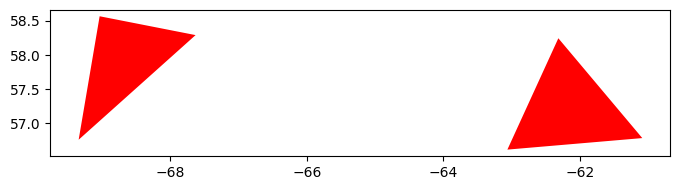

In [11]:
location_wkt = textarea_input.value
location_wgs84 = gpd.GeoSeries(shapely.wkt.loads(location_wkt))
location_wgs84.crs = "EPSG:4326"

sec_wgs84 = gp.get_sec(location_wgs84)
centroid_wgs84 = gp.get_sec_centroid(sec_wgs84, 4326)

fig, ax = plt.subplots(figsize=(8, 8))
location_wgs84.plot(aspect = "equal", color = "red", ax = ax)

<Axes: >

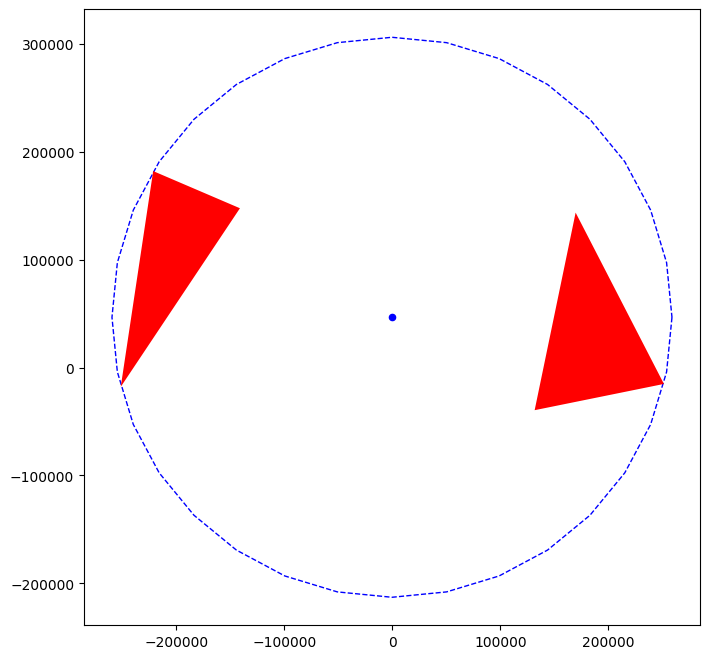

In [12]:
proj_aeqd = gp.get_aeqd_proj(location_wgs84)
location_aeqd = location_wgs84.to_crs(proj_aeqd)
sec_aeqd = gp.get_sec(location_aeqd)
centroid_aeqd = gp.get_sec_centroid(sec_aeqd, 4326)

fig, ax = plt.subplots(figsize=(8, 8))
sec_aeqd.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)

## Eventual geometry simplification

In [18]:
max_points_polygon =10000
tolerance = 500

# Note: For each polygon it counts twice the starting vertex since it is also the ending one
#       However, that does not matter for our purposes
n = len(location_aeqd.get_coordinates())

if(n > max_points_polygon):
  location_aeqd = location_aeqd.simplify(tolerance)  

<Axes: >

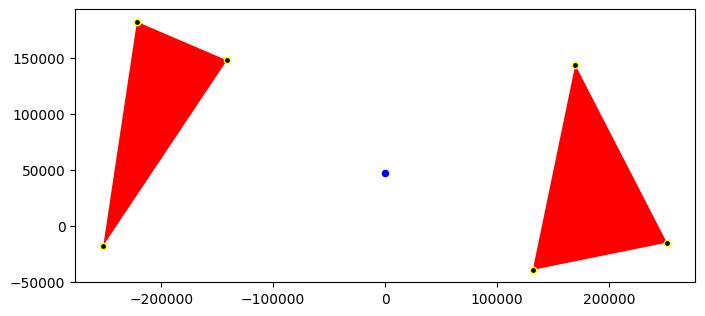

In [13]:
vertices = gp.get_all_vertices(location_aeqd)
fig, ax = plt.subplots(figsize=(8, 8))
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)

<Axes: >

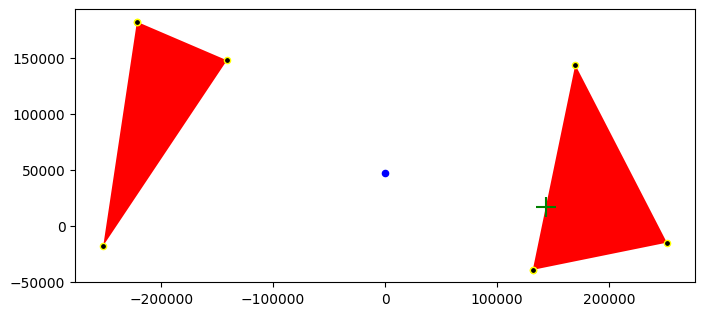

In [14]:
np = gp.get_nearest_point(centroid_aeqd, location_aeqd, proj_aeqd)

fig, ax = plt.subplots(figsize=(8, 8))
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
np.plot(aspect = "equal", color = "green", marker="+", markersize = 200, ax = ax)

## First approximation

<class 'geopandas.geodataframe.GeoDataFrame'>


<Axes: >

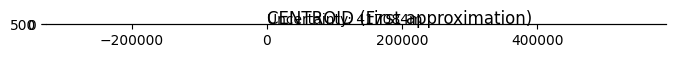

In [15]:
candidates = gp.get_candidate_vertices(vertices)
fa = gp.get_minimum_distance_candidate(candidates, vertices)
centroid_fa = gpd.GeoSeries(fa[0])
centroid_fa.crs = proj_aeqd
radius_fa = fa[1]
sec_fa = gpd.GeoSeries(centroid_fa.buffer(radius_fa))
sec_fa.crs = proj_aeqd

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim(-300, 550)
ax.text(-450, 500, 'CENTROID (First approximation)', fontsize=12, color='black')
ax.text(-450, 465, f"Uncertainty: {radius_fa:.0f}m", fontsize=10, color='black')
sec_fa.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
np.plot(aspect = "equal", color = "green", marker="+", markersize = 200, ax = ax)
candidates.plot(aspect = "equal", color = "green", ax = ax)
centroid_fa.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)


## Second approximation


/Users/arnald/Library/CloudStorage/OneDrive-UAB/wb/GeoPick/py/geopick.py:92: UserWarning: The indices of the two GeoSeries are different.
  distances = point.distance(vertices)


<Axes: >

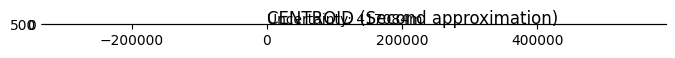

In [16]:
np_centroid_fa = gp.get_nearest_n_vertices(vertices, centroid_fa, 10)
sa = gp.get_minimum_distance_candidate(np_centroid_fa, vertices)
centroid_sa = gpd.GeoSeries(sa[0])
centroid_sa.crs = proj_aeqd
radius_sa = sa[1]
sec_sa = gpd.GeoSeries(centroid_fa.buffer(radius_sa))
sec_sa.crs = proj_aeqd

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim(-300, 550)
ax.text(-450, 500, 'CENTROID (Second approximation)', fontsize=12, color='black')
ax.text(-450, 465, f"Uncertainty: {radius_sa:.0f}m", fontsize=10, color='black')
sec_fa.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
np.plot(aspect = "equal", color = "green", marker="+", markersize = 200, ax = ax)
candidates.plot(aspect = "equal", color = "green", ax = ax)
np_centroid_fa.plot(aspect = "equal", color = "yellow", ax = ax)
centroid_fa.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)

## Final result

<Axes: >

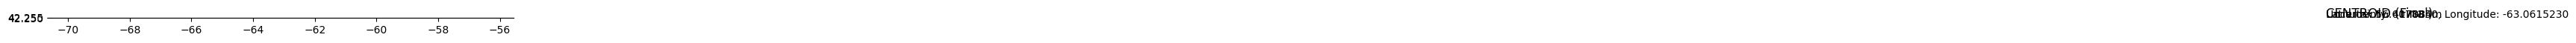

In [17]:
if(radius_sa < radius_fa):
  sec_final = sa
else:
  sec_final = fa

centroid_final = gpd.GeoSeries(sec_final[0])
centroid_final.crs = proj_aeqd
radius_final = sec_final[1]
sec_final = gpd.GeoSeries(centroid_final.buffer(radius_final))
centroid_final = centroid_final.to_crs(4326)
sec_final = sec_final.to_crs(4326)
centroid_final_coords = centroid_final.get_coordinates()
centroid_string = f"Latitude: {centroid_final_coords['y'].iloc[0]:.7f}, \
Longitude: {centroid_final_coords['x'].iloc[0]:.7f}"

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim(42.247, 42.255)
ax.text(3.2345, 42.2545, 'CENTROID (Final)', fontsize=12, color='black')
ax.text(3.2345, 42.2541, centroid_string, fontsize=10, color='black')
ax.text(3.2345, 42.2538, f"Uncertainty: {radius_final:.0f}m", fontsize=10, color='black')
location_wgs84.plot(aspect = "equal", color = "red", ax = ax)
sec_final.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
centroid_final.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)
